In [1]:
import os
import glob
import sys

# --- 0. 關鍵修復：禁用 Qt OpenGL 整合 ---
# 這是為了解決 WSL2 中 Intel 驅動 (libigc.so) 與 TensorFlow 的 LLVM 版本衝突導致的 Segfault
# 必須在導入 PyQt5 之前設定
os.environ['QT_XCB_GL_INTEGRATION'] = 'none'

# --- 解決 Jupyter Kernel 崩潰問題 ---
# 在導入 TensorFlow 之前，強制將 conda 環境中的 NVIDIA 函式庫路徑加入 LD_LIBRARY_PATH
# 這解決了 "Cannot dlopen some GPU libraries" 導致的 Segfault (核心崩潰)

try:
    # 1. 嘗試獲取 Conda 環境路徑
    conda_prefix = os.environ.get('CONDA_PREFIX')
    
    # 如果沒有 CONDA_PREFIX，嘗試從 sys.executable 推斷 (例如 /home/user/miniconda3/envs/moon_gpu/bin/python)
    if not conda_prefix:
        conda_prefix = os.path.dirname(os.path.dirname(sys.executable))
    
    if conda_prefix:
        # 2. 尋找所有 nvidia 相關的 lib 目錄
        nvidia_lib_pattern = os.path.join(conda_prefix, 'lib', 'python3.10', 'site-packages', 'nvidia', '*', 'lib')
        nvidia_libs = glob.glob(nvidia_lib_pattern)
        
        if nvidia_libs:
            # 3. 組合路徑
            nvidia_path_str = ':'.join(nvidia_libs)
            current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')
            
            # 4. 設定環境變數 (這必須在 import tensorflow 之前完成)
            os.environ['LD_LIBRARY_PATH'] = f"{nvidia_path_str}:{current_ld_path}"
            print(f"✅ 已自動設定 NVIDIA 函式庫路徑 ({len(nvidia_libs)} 個目錄)")
        else:
            print("⚠️ 未找到 NVIDIA 函式庫，如果 GPU 無法使用請檢查安裝")
    else:
        print("⚠️ 無法偵測 Conda 環境，跳過路徑修復")

except Exception as e:
    print(f"⚠️ 路徑修復時發生錯誤: {e}")

# --- 接下來正常導入 ---
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")

✅ 已自動設定 NVIDIA 函式庫路徑 (11 個目錄)


I0000 00:00:1765729563.413648  149881 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765729563.449196  149881 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765729564.272031  149881 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow Version: 2.21.0-dev20251208


In [2]:
import sys
import os
import tensorflow as tf
# 確認工作目錄
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# 確保專案根目錄在 sys.path 中 (通常預設就在，但為了保險起見)
if current_dir not in sys.path:
    sys.path.append(current_dir)
    print(f"Added {current_dir} to sys.path")

# 注意：我們不再將 'src' 加入 sys.path，因為我們現在使用 'from src.xxx import yyy' 的方式
# 這樣可以避免模組名稱衝突並保持結構清晰

print("TensorFlow Version:", tf.__version__)

# 列出實體 GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")

if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print(f"GPU Name: {details.get('device_name', 'Unknown')}")
    print("GPU Setup Success! Ready for training.")
else:
    print("No GPU found. Please check nvidia-smi.")

Current working directory: /home/bruh_bruh/moon_doodle_project
Added /home/bruh_bruh/moon_doodle_project to sys.path
TensorFlow Version: 2.21.0-dev20251208
Num GPUs Available: 1
GPU Name: NVIDIA GeForce RTX 5070 Ti Laptop GPU
GPU Setup Success! Ready for training.


W0000 00:00:1765729565.080900  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765729565.146310  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765729565.146641  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765729565.146653  149881 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765729565.147897  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

# -1.Pre-train your model(should do it VERY carefully！！！)

In [ ]:
from src.train_sog import train_with_greedy

# 執行預訓練
# num_games: 生成多少場 Greedy 對局 (建議 100-500)
# epochs: 在這些數據上訓練幾輪 (建議 5-10)
train_with_greedy(num_games=50, epochs=2)

## 1. 啟動遊戲 (PvP / PvAI)
執行下方儲存格以開啟遊戲視窗。

In [ ]:
import sys
from PyQt5.QtWidgets import QApplication
from src.New_moon_game import MainWindow
from src.ai_logic import GreedyAI, StudentOfGamesAI
import os

# 確保只有一個 QApplication 實例
app = QApplication.instance()
if app is None:
    app = QApplication(sys.argv)

# 設定 AI (可選)
# P2 使用 StudentOfGames (如果模型存在)，否則使用 GreedyAI
model_path = os.path.join(current_dir, 'models', 'sog_model.keras')
if os.path.exists(model_path):
    print("Loading StudentOfGames AI...")
    # 注意：這裡需要知道 input_dim 和 num_actions，通常從 train_sog 導入或寫死
    # 為了簡化，這裡假設使用預設地圖 (Large)
    from src.adj_map import DEFAULT_BOARD
    NUM_NODES = len(DEFAULT_BOARD.adj_map)
    INPUT_DIM = 12 * NUM_NODES + 27
    NUM_ACTIONS = 3 * NUM_NODES
else:
    print("Model not found")

# StudentOfGamesAI('SOG', model_path=model_path, num_actions=NUM_ACTIONS)
ai_players = {
    'P2': GreedyAI("greebot")
}

window = MainWindow(ai_players=ai_players)
window.show()

# 在 Notebook 中執行 PyQt5 事件迴圈
app.exec_()

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


Loading StudentOfGames AI...


0

## 2. 視覺化訓練 (Training with UI)
執行下方儲存格以開啟訓練視窗，即時觀看 Student of Games 自我對戰與學習過程。

In [ ]:
import sys
from PyQt5.QtWidgets import QApplication
from src.train_with_ui import TrainingWindow

app = QApplication.instance()
if app is None:
    app = QApplication(sys.argv)

train_window = TrainingWindow()
train_window.show()

app.exec_()

## 3. 背景訓練 (Headless Training)
如果不想要 UI，可以直接執行背景訓練腳本。

In [3]:
from src.train_sog import train
# 開始訓練 (會佔用此 Kernel 直到手動停止)
train()

Using Linux native path for models: /home/bruh_bruh/moon_doodle_project
Initializing StudentOfGamesAI...
Loading model from /home/bruh_bruh/moon_doodle_project/models/sog_model.keras


W0000 00:00:1765729568.231111  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765729568.232112  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765729568.232437  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765729568.232454  149881 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765729568.367023  149881 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us


We could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 1, 29), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>',)
  • kwargs={'mask': 'None'}). Rebuilding model and loading weights...


/home/bruh_bruh/miniconda3/envs/moon_gpu/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Weights loaded successfully.
Loaded history with buffer: starting from epoch 24, buffer size 20

=== Epoch 25/1000 ===
Starting self-play game 1/5


I0000 00:00:1765729569.594153  149982 service.cc:153] XLA service 0x73fedc047c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765729569.594177  149982 service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5070 Ti Laptop GPU, Compute Capability 12.0a
I0000 00:00:1765729569.602725  149982 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765729569.664937  149982 cuda_dnn.cc:461] Loaded cuDNN version 91700
I0000 00:00:1765729570.740281  149982 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Game finished. Winner: P2, Score: 11-35
Starting self-play game 2/5
Game finished. Winner: P1, Score: 29-17
Starting self-play game 3/5
Game finished. Winner: P2, Score: 17-31
Starting self-play game 4/5
Game finished. Winner: P1, Score: 21-20
Starting self-play game 5/5
Game finished. Winner: P1, Score: 29-28
Training on 19200 samples (Buffer: 20 batches)...
Epoch 1/5


I0000 00:00:1765729615.227822  150291 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1765729615.238154  150275 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 4 bytes spill stores, 4 bytes spill loads



300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.0458 - policy_loss: 2.9414 - value_loss: 0.1044
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0176 - policy_loss: 2.9329 - value_loss: 0.0848
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9903 - policy_loss: 2.9176 - value_loss: 0.0726
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9775 - policy_loss: 2.9106 - value_loss: 0.0670
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ -1s -2057us/step - loss: 2.9631 - policy_loss: 2.9014 - value_loss: 0.0617
  > Training Loss: 2.9989 (Policy: 2.9208, Value: 0.0781)
Model saved to /home/bruh_bruh/moon_doodle_project/models/sog_model.keras
History saved to /home/bruh_bruh/moon_doodle_project/models/training_history.pkl

=== Epoch 26/1000 ===
Starting self-play game 1/5
Game finished. Winner: P2, Score: 30-36
Starting self-play game 2/5
Game finished. Winner: P1, Score: 39-24
Starting self-play game 3/5
Game finished. Winner: Draw, Score: 25-25
Starting self-play

KeyboardInterrupt: 

## 4. 訓練數據分析 (Training Analysis)
讀取 `models/training_history.pkl` 並繪製 Loss 曲線與勝率變化。

已載入訓練紀錄：共 55 Epochs


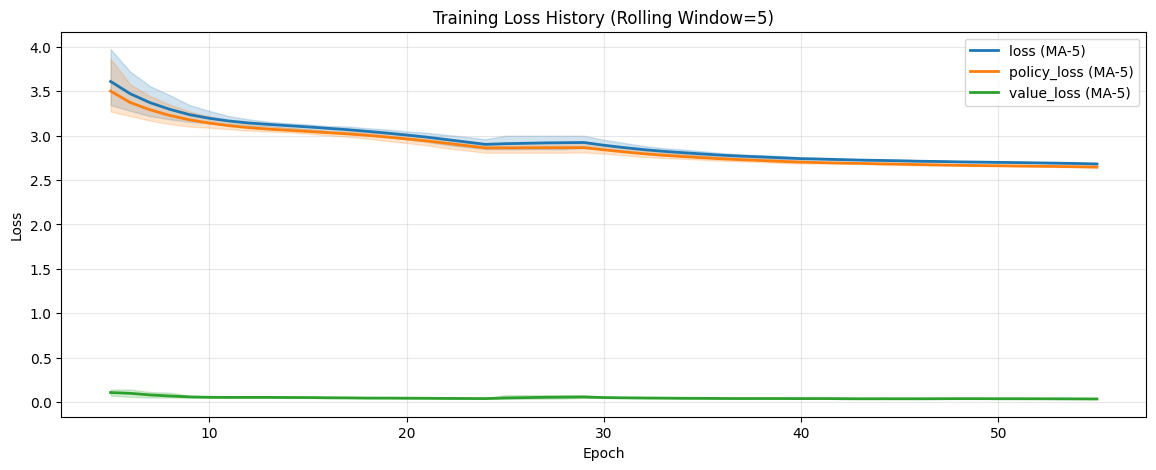

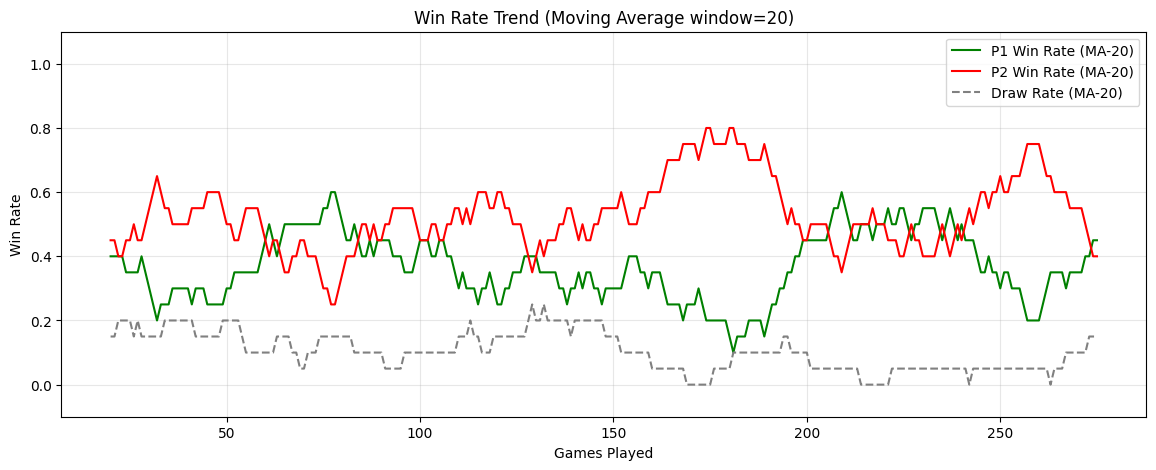

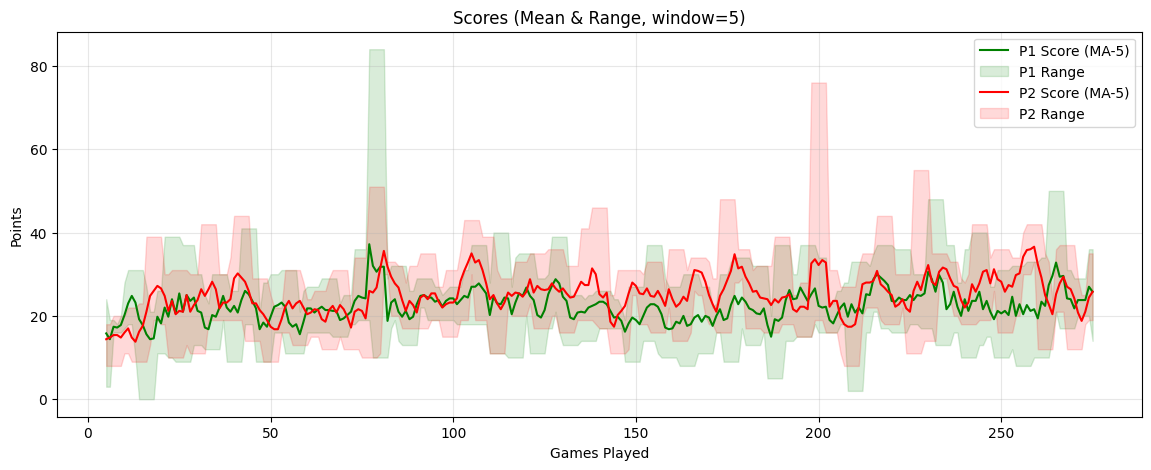

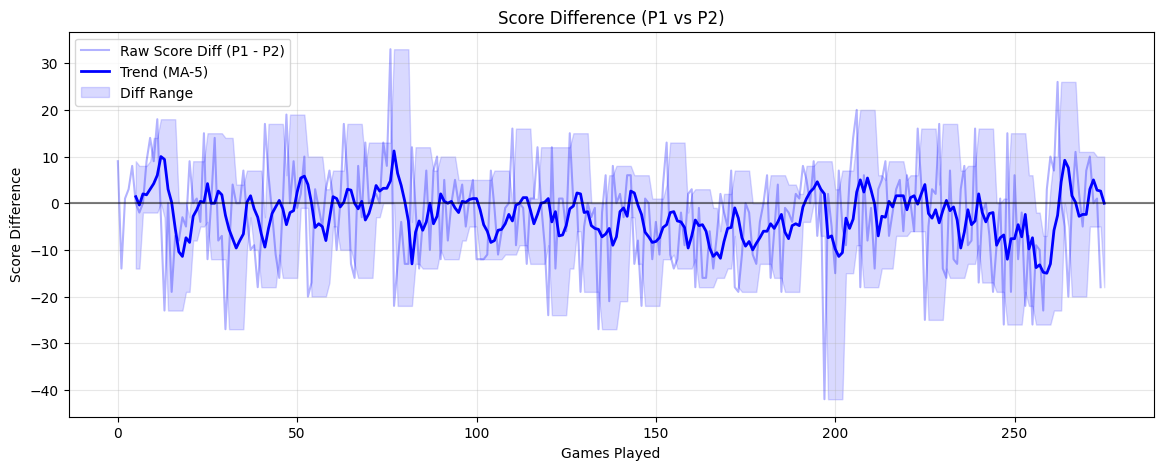


Recent Games:
Game 271: Winner=P1, Score=27-20, Steps=24
Game 272: Winner=P1, Score=29-19, Steps=24
Game 273: Winner=Draw, Score=23-23, Steps=24
Game 274: Winner=P1, Score=36-35, Steps=24
Game 275: Winner=P2, Score=14-32, Steps=24


In [9]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np

# 設定路徑
history_path = os.path.join(os.getcwd(), 'models', 'training_history.pkl')

if not os.path.exists(history_path):
    print(f"尚未找到訓練紀錄: {history_path}")
    print("請先執行訓練 (Training) 以產生數據。")
else:
    try:
        with open(history_path, 'rb') as f:
            data = pickle.load(f)
            # 相容性檢查：確保數據格式正確
            if len(data) == 4:
                epoch, loss_history, game_record,pipi = data
                print(f"已載入訓練紀錄：共 {epoch} Epochs")
            else:
                print("紀錄格式不符，無法分析。")
                epoch, loss_history, game_record = 0, [], []
    except Exception as e:
        print(f"讀取錯誤: {e}")
        loss_history = []
        game_record = []

    # Helper function for rolling statistics
    def get_rolling_stats(data, window_size):
        data = np.array(data)
        if len(data) < window_size:
            return None, None, None
        
        means = []
        mins = []
        maxs = []
        for i in range(len(data) - window_size + 1):
            window = data[i : i + window_size]
            means.append(np.mean(window))
            mins.append(np.min(window))
            maxs.append(np.max(window))
        return np.array(means), np.array(mins), np.array(maxs)

    # --- 1. 繪製 Loss 曲線 ---
    if loss_history:
        plt.figure(figsize=(14, 5))
        
        keys = loss_history[0].keys()
        loss_window = 5 # Window size for loss smoothing
        
        for key in keys:
            vals = [x[key] for x in loss_history]
            
            if len(vals) >= loss_window:
                l_mean, l_min, l_max = get_rolling_stats(vals, loss_window)
                x_axis = range(loss_window, len(vals) + 1)
                
                p = plt.plot(x_axis, l_mean, label=f'{key} (MA-{loss_window})', linewidth=2)
                color = p[0].get_color()
                plt.fill_between(x_axis, l_min, l_max, color=color, alpha=0.2)
            else:
                plt.plot(range(1, len(vals)+1), vals, label=key, linewidth=2)
            
        plt.title(f'Training Loss History (Rolling Window={loss_window})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # --- 2. 繪製對戰結果分析 ---
    if game_record:
        # 提取勝負數據
        p1_wins = [1 if g['winner'] == 'P1' else 0 for g in game_record]
        p2_wins = [1 if g['winner'] == 'P2' else 0 for g in game_record]
        draws = [1 if g['winner'] == 'Draw' else 0 for g in game_record]
        
        window = min(5, len(game_record))
        
        if window > 1:
            # Win Rate
            w_mean_p1, _, _ = get_rolling_stats(p1_wins, 20)
            w_mean_p2, _, _ = get_rolling_stats(p2_wins, 20)
            w_mean_draw, _, _ = get_rolling_stats(draws, 20)
            
            if w_mean_p1 is not None:
                plt.figure(figsize=(14, 5))
                x_axis = range(20, len(game_record) + 1)
                
                plt.plot(x_axis, w_mean_p1, label=f'P1 Win Rate (MA-{20})', color='green')
                plt.plot(x_axis, w_mean_p2, label=f'P2 Win Rate (MA-{20})', color='red')
                plt.plot(x_axis, w_mean_draw, label=f'Draw Rate (MA-{20})', color='gray', linestyle='--')
                
                plt.title(f'Win Rate Trend (Moving Average window={20})')
                plt.xlabel('Games Played')
                plt.ylabel('Win Rate')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.ylim(-0.1, 1.1)
                plt.show()
        
        # Scores with Range
        p1_scores = [g['p1_score'] for g in game_record]
        p2_scores = [g['p2_score'] for g in game_record]
        
        p1_mean, p1_min, p1_max = get_rolling_stats(p1_scores, window)
        p2_mean, p2_min, p2_max = get_rolling_stats(p2_scores, window)
        
        if p1_mean is not None:
            plt.figure(figsize=(14, 5))
            x_axis = range(window, len(game_record) + 1)
            
            # P1
            plt.plot(x_axis, p1_mean, color='green', label=f'P1 Score (MA-{window})')
            plt.fill_between(x_axis, p1_min, p1_max, color='green', alpha=0.15, label='P1 Range')
            
            # P2
            plt.plot(x_axis, p2_mean, color='red', label=f'P2 Score (MA-{window})')
            plt.fill_between(x_axis, p2_min, p2_max, color='red', alpha=0.15, label='P2 Range')
            
            plt.title(f'Scores (Mean & Range, window={window})')
            plt.xlabel('Games Played')
            plt.ylabel('Points')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
        # Score Diff
        score_diffs = [g['p1_score'] - g['p2_score'] for g in game_record]
        d_mean, d_min, d_max = get_rolling_stats(score_diffs, window)
        
        plt.figure(figsize=(14, 5))
        plt.plot(score_diffs, alpha=0.3, color='blue', label='Raw Score Diff (P1 - P2)')
        
        if d_mean is not None:
            x_axis = range(window, len(game_record) + 1)
            plt.plot(x_axis, d_mean, color='blue', linewidth=2, label=f'Trend (MA-{window})')
            plt.fill_between(x_axis, d_min, d_max, color='blue', alpha=0.15, label='Diff Range')
            
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Score Difference (P1 vs P2)')
        plt.xlabel('Games Played')
        plt.ylabel('Score Difference')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 顯示最近 5 場數據
        print("\nRecent Games:")
        for i, g in enumerate(game_record[-5:]):
            print(f"Game {len(game_record)-4+i}: Winner={g['winner']}, Score={g['p1_score']}-{g['p2_score']}, Steps={g['steps']}")